In [7]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [8]:
%load_ext autoreload
%autoreload 2

from rdkit import RDLogger
from utils import generator_from_conf, conf_from_yaml
RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        conf = conf_from_yaml(yaml_path, repo_root)
        generator = generator_from_conf(conf, repo_root)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


seed: 1751873418
Starting generation...
<Best reward updated> 1 - time: 0.00, reward: 0.0000, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2csc3nc(Cl)ncc23)n1
<Best reward updated> 2 - time: 0.00, reward: 0.5200, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2csc3ncnc([N+](=O)[O-])c23)n1
<Best reward updated> 4 - time: 0.00, reward: 0.5697, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2csc3nc(F)ncc23)n1
<Best reward updated> 7 - time: 0.00, reward: 0.5867, node: Cc1sc2ncncc2c1[C@@H](O)c1nc(N)nc(C(=O)[O-])n1
<Best reward updated> 9 - time: 0.00, reward: 0.6008, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2c(Cl)sc3ncncc23)n1
<Best reward updated> 11 - time: 0.00, reward: 0.6135, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2c(O)sc3ncncc23)n1
<Best reward updated> 12 - time: 0.00, reward: 0.6196, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2c(F)sc3ncncc23)n1
100 - time: 1.03, average over 100: 0.3971
<Best reward updated> 110 - time: 1.16, reward: 0.6248, node: Nc1nc(C(=O)[O-])nc([C@H](O)c2c(N)sc3ncncc23)n1
200 - time: 2.11, average over 100: 0.3413
30

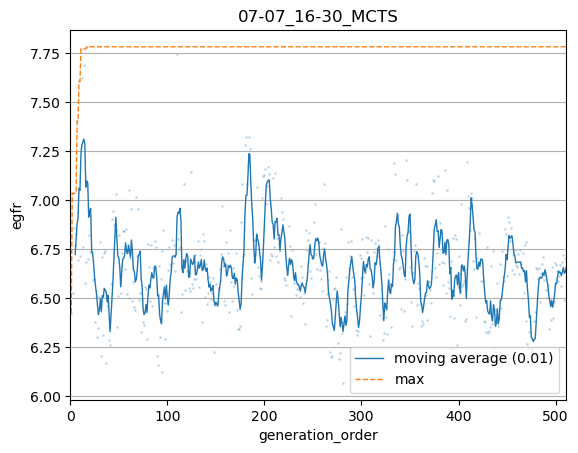

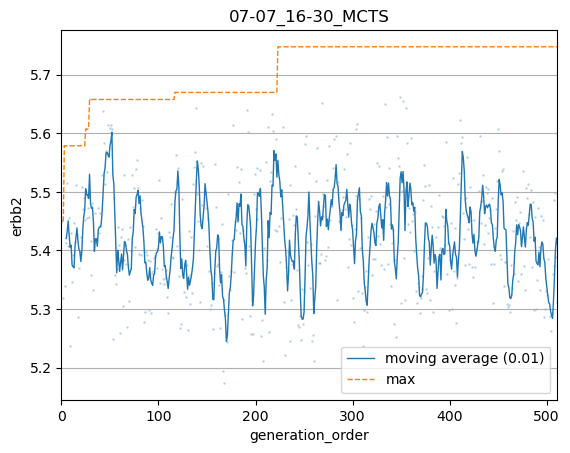

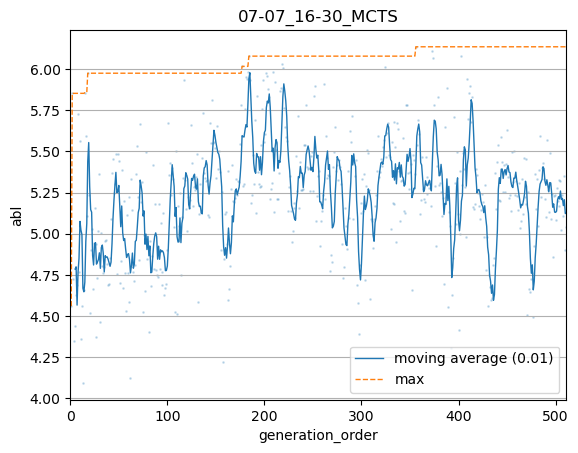

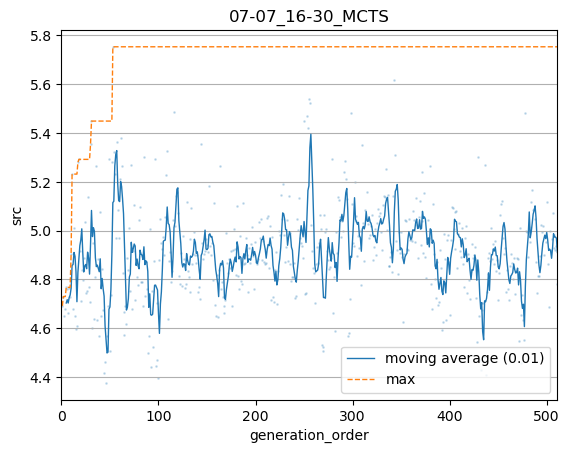

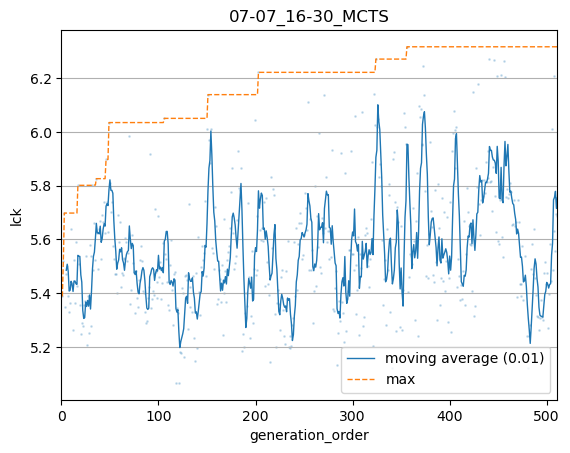

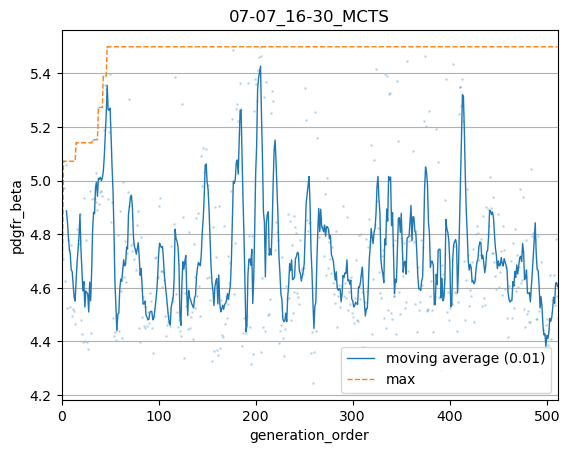

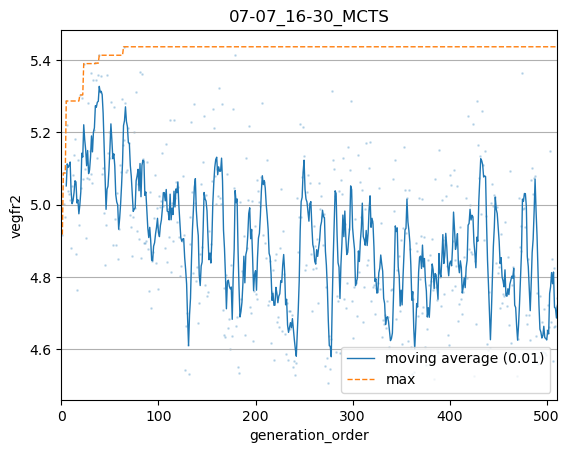

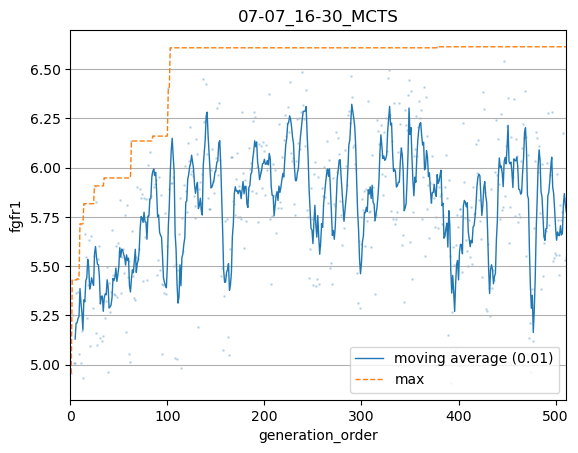

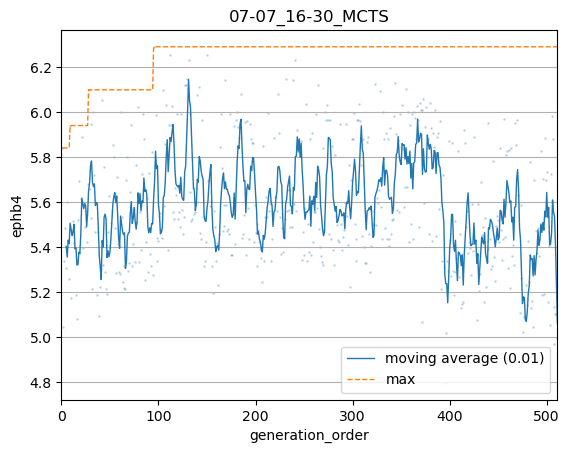

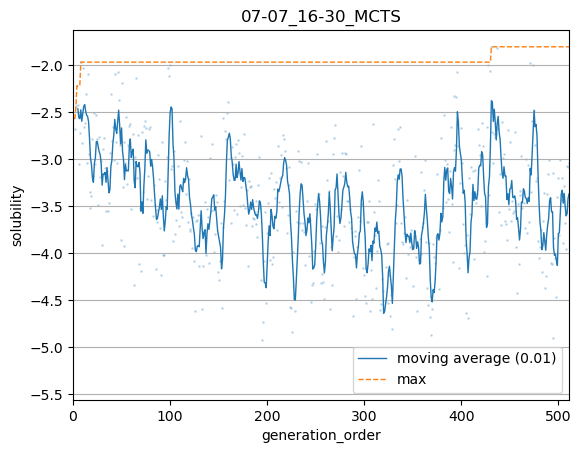

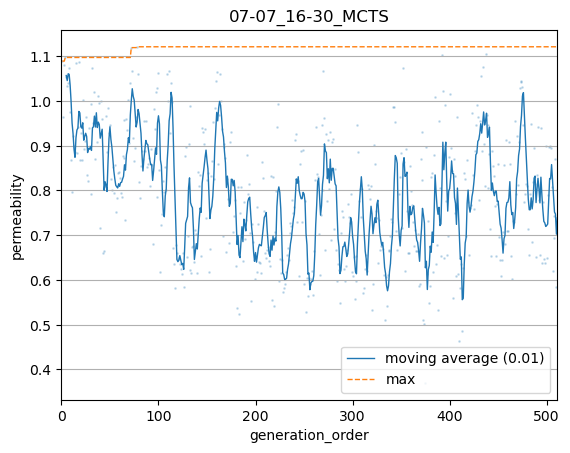

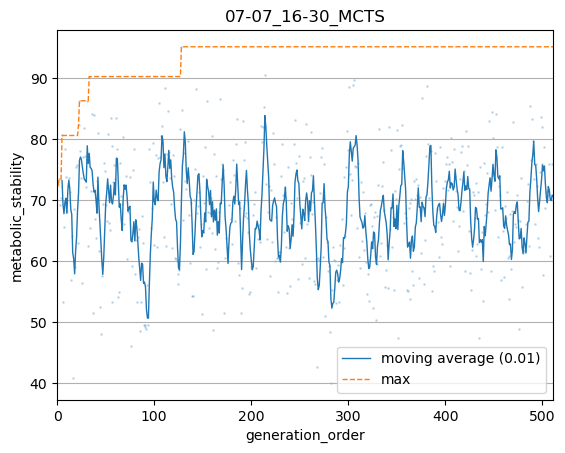

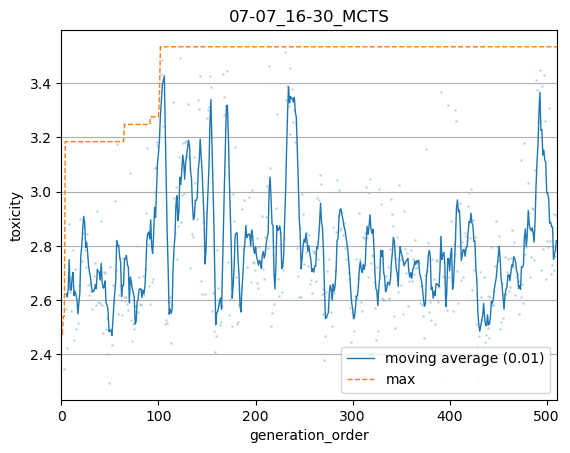

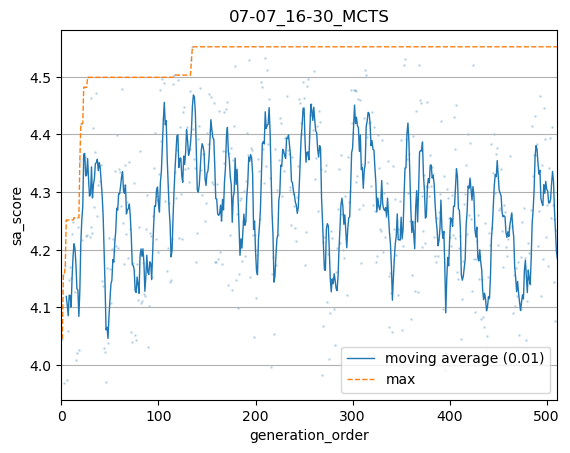

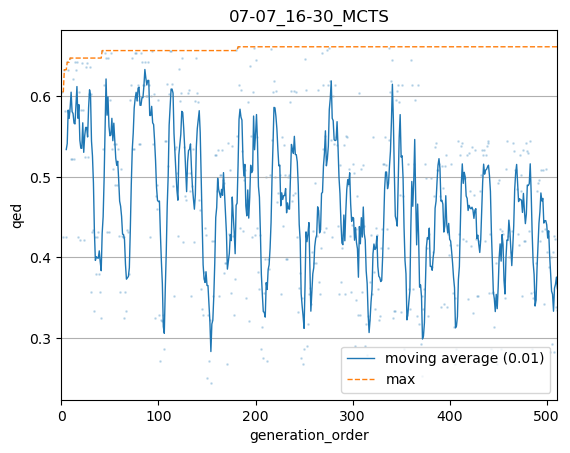

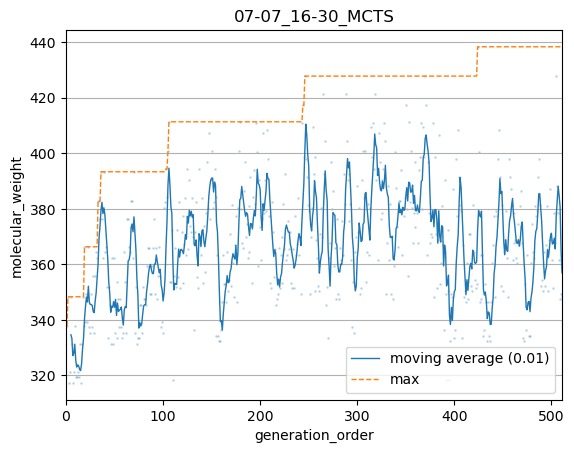

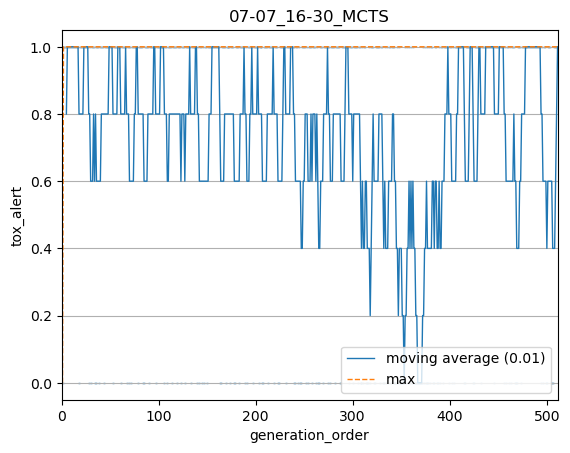

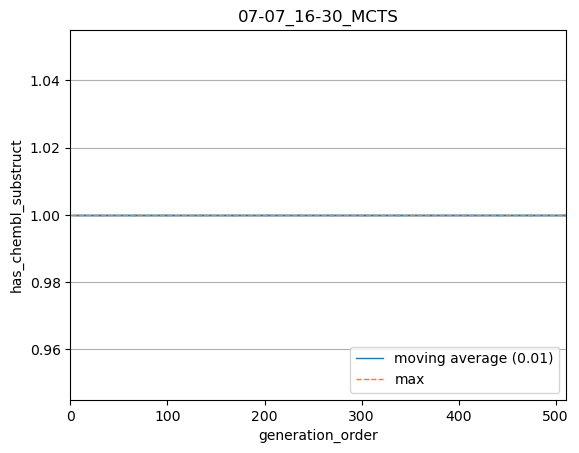

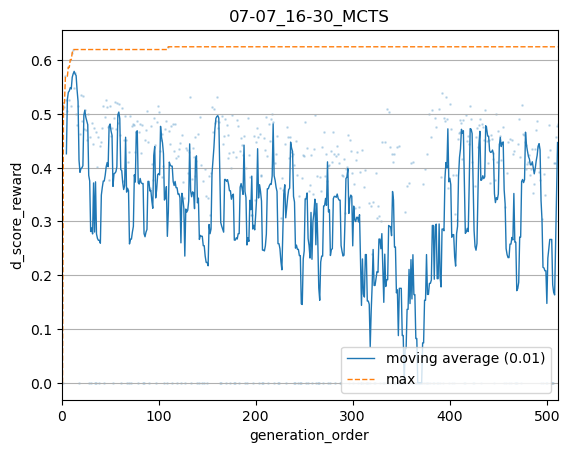

number of generated nodes: 511
valid rate: 1.0
unique rate: 0.14253835425383543
node_per_sec: 72.94076073375102
best_reward: 0.6247601557629335
average_reward: 0.3197169509180223


In [10]:
# start generation

# yaml_path = "config/mcts_helm.yaml"
# yaml_path = "config/mcts_smiles.yaml"
# yaml_path = "config/model_test.yaml"
# yaml_path = "config/mcts_d_score.yaml"
# yaml_path = "config/mcts_biot5.yaml"
yaml_path = "config/mcts_smarts.yaml"

conf = conf_from_yaml(yaml_path, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

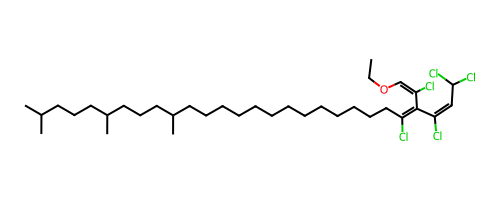

In [14]:
from node import MolStringNode
from language import SELFIES
from utils import draw_mol
x = MolStringNode.node_from_key("[C][C][O][C][=C][Branch1][C][Cl][C][=C][Branch1][C][Cl][C][Branch2][Ring2][=Branch2][C][C][C][C][C][C][C][C][C][C][C][C][C][Branch1][C][C][C][C][C][C][Branch1][C][C][C][C][C][C][Branch1][C][C][C].[Cl][=C][Branch1][C][Cl][C][=C][Ring2][Ring2][C][Cl]", lang=SELFIES())
mol = x.mol()
draw_mol(mol, 500, 200)

In [ ]:
# continue generation
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

Starting generation...


In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
from generator import Generator
load_dir = "generation_result/06-26_08-51/"
conf = conf_from_yaml("sandbox/" + load_dir + "setting.yaml", repo_root)
generator = generator_from_conf(conf, repo_root)
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
conf = conf_from_yaml(yaml_path, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)